In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

12104


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 217


In [6]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm65_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': True,
 'flip_vertical': False,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [7]:
for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[750,488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )
    

## Check result

<IPython.core.display.Javascript object>


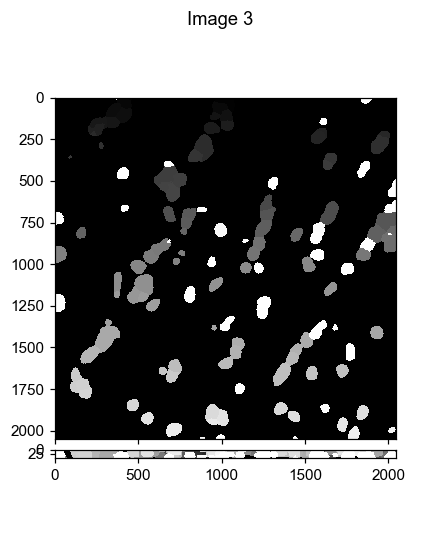

In [9]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, _cls.im_750, labels3d])

## Watershed

In [8]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed


In [13]:
for _fov_id, _fov_name in enumerate(fovs):
    
    _save_id = _fov_id
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file)
    
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    # Prepare watershed
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    new_labels = ndimage.grey_dilation(new_labels, structure=morphology.ball(1))
    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_1.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.937s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.376s.
-- corrected illumination for channel 405 in 4.339s.
- Finished illumination correction in 8.860s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin

- Loaded images for channels:['750', '488'] in 0.665s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.233s.
-- corrected illumination for channel 488 in 1.117s.
- Finished illumination correction in 2.464s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.03 -3.51  4.5 ] in 0.543s.
-- drift 1: [ 0.02 -3.44  4.47] in 0.611s.
-- drift 2: [ 0.04 -3.49  4.56] in 0.563s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.03 -3.48  4.51] for channel: 750
-- finish warpping channel 750 in 16.384s.
488 False True
-- warp image with drift:[ 0.03 -3.48  4.51] for channel: 488
-- finish warpping channel 488 in 16.369s

- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_8.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 3.110s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.285s.
-- corrected illumination for channel 405 in 4.295s.
- Finished illumination correction in 8.668s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin

-- corrected illumination for channel 750 in 1.102s.
-- corrected illumination for channel 488 in 1.104s.
- Finished illumination correction in 2.278s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01 -3.65  4.95] in 0.556s.
-- drift 1: [ 0.   -3.58  4.98] in 0.631s.
-- drift 2: [ 0.01 -3.6   5.  ] in 0.565s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00666667 -3.61        4.97666667] for channel: 750
-- finish warpping channel 750 in 16.489s.
488 False True
-- warp image with drift:[ 0.00666667 -3.61        4.97666667] for channel: 488
-- finish warpping channel 488 in 16.679s.
-- finish warpping in 33.168s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_11.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brai

Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_015.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.931s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.270s.
-- corrected illumination for channel 405 in 4.375s.
- Finished illumination correction in 8.784s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_015.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.623s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profil

-- corrected illumination for channel 488 in 1.151s.
- Finished illumination correction in 2.366s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.01 -3.54  3.54] in 0.588s.
-- drift 1: [ 0.01 -3.53  3.64] in 0.580s.
-- drift 2: [ 0.01 -3.6   3.58] in 0.592s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01       -3.55666667  3.58666667] for channel: 750
-- finish warpping channel 750 in 16.334s.
488 False True
-- warp image with drift:[ 0.01       -3.55666667  3.58666667] for channel: 488
-- finish warpping channel 488 in 16.423s.
-- finish warpping in 32.757s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_18.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_

- Loaded images for channels:['488', '405'] in 3.554s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.256s.
-- corrected illumination for channel 405 in 4.332s.
- Finished illumination correction in 8.790s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_022.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.817s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.107s.
-- corrected illumination for channel 488 in 1.105s.


-- drift 0: [ 0.01 -3.23  4.17] in 0.580s.
-- drift 1: [ 0.   -3.15  4.3 ] in 0.529s.
-- drift 2: [ 0.01 -3.16  4.29] in 0.607s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00666667 -3.18        4.25333333] for channel: 750
-- finish warpping channel 750 in 16.360s.
488 False True
-- warp image with drift:[ 0.00666667 -3.18        4.25333333] for channel: 488
-- finish warpping channel 488 in 16.352s.
-- finish warpping in 32.713s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_25.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_26.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_026.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_026.dax
Initialize 

- Loaded images for channels:['488', '405'] in 2.970s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.288s.
-- corrected illumination for channel 405 in 4.290s.
- Finished illumination correction in 8.738s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_029.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.679s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.085s.
-- corrected illumination for channel 488 in 1.086s.


-- drift 0: [ 0.01 -4.04  4.56] in 0.553s.
-- drift 1: [ 0.01 -4.05  4.61] in 0.568s.
-- drift 2: [ 0.02 -4.02  4.47] in 0.573s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01333333 -4.03666667  4.54666667] for channel: 750
-- finish warpping channel 750 in 16.270s.
488 False True
-- warp image with drift:[ 0.01333333 -4.03666667  4.54666667] for channel: 488
-- finish warpping channel 488 in 16.331s.
-- finish warpping in 32.602s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_32.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_33.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_033.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_033.dax
Initialize 

- Loaded images for channels:['488', '405'] in 2.901s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.575s.
-- corrected illumination for channel 405 in 4.525s.
- Finished illumination correction in 9.204s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_036.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.657s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.121s.
-- corrected illumination for channel 488 in 1.120s.


-- drift 0: [ 0.01 -3.45  2.76] in 0.570s.
-- drift 1: [ 0.01 -3.44  2.76] in 0.604s.
-- drift 2: [ 0.01 -3.38  2.72] in 0.589s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01       -3.42333333  2.74666667] for channel: 750
-- finish warpping channel 750 in 16.451s.
488 False True
-- warp image with drift:[ 0.01       -3.42333333  2.74666667] for channel: 488
-- finish warpping channel 488 in 16.668s.
-- finish warpping in 33.120s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_39.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_40.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_040.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_040.dax
Initialize 

- Loaded images for channels:['488', '405'] in 3.548s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.318s.
-- corrected illumination for channel 405 in 4.302s.
- Finished illumination correction in 8.749s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_043.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.622s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.092s.
-- corrected illumination for channel 488 in 1.101s.


-- drift 0: [ 0.01 -3.28  4.19] in 0.549s.
-- drift 1: [ 0.   -3.23  4.22] in 0.564s.
-- drift 2: [ 0.01 -3.22  4.18] in 0.538s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00666667 -3.24333333  4.19666667] for channel: 750
-- finish warpping channel 750 in 16.318s.
488 False True
-- warp image with drift:[ 0.00666667 -3.24333333  4.19666667] for channel: 488
-- finish warpping channel 488 in 16.357s.
-- finish warpping in 32.675s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_46.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_47.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_047.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_047.dax
Initialize 

- Loaded images for channels:['488', '405'] in 3.313s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.307s.
-- corrected illumination for channel 405 in 4.316s.
- Finished illumination correction in 8.769s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_050.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.626s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.219s.
-- corrected illumination for channel 488 in 1.104s.


-- drift 0: [ 0.02 -3.31  3.66] in 0.555s.
-- drift 1: [ 0.   -3.28  3.7 ] in 0.570s.
-- drift 2: [ 0.01 -3.05  3.68] in 0.574s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01       -3.21333333  3.68      ] for channel: 750
-- finish warpping channel 750 in 16.238s.
488 False True
-- warp image with drift:[ 0.01       -3.21333333  3.68      ] for channel: 488
-- finish warpping channel 488 in 16.318s.
-- finish warpping in 32.556s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_53.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_54.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_054.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_054.dax
Initialize 

- Loaded images for channels:['488', '405'] in 2.891s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.273s.
-- corrected illumination for channel 405 in 4.288s.
- Finished illumination correction in 8.653s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_057.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.706s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.087s.
-- corrected illumination for channel 488 in 1.087s.


-- drift 0: [ 0.   -4.74  3.17] in 0.562s.
-- drift 1: [ 0.   -4.66  3.2 ] in 0.557s.
-- drift 2: [ 0.  -4.7  3.2] in 0.602s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.   -4.7   3.19] for channel: 750
-- finish warpping channel 750 in 16.264s.
488 False True
-- warp image with drift:[ 0.   -4.7   3.19] for channel: 488
-- finish warpping channel 488 in 16.723s.
-- finish warpping in 32.987s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_60.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_61.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_061.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_061.dax
Initialize DaxProcesser for file:\\10.245.74.158\C

- Loaded images for channels:['488', '405'] in 3.181s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.277s.
-- corrected illumination for channel 405 in 4.291s.
- Finished illumination correction in 8.657s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_064.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.645s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.088s.
-- corrected illumination for channel 488 in 1.083s.


-- drift 0: [ 0.   -2.8   2.81] in 0.549s.
-- drift 1: [ 0.01 -2.85  2.86] in 0.600s.
-- drift 2: [ 0.   -2.73  2.78] in 0.545s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00333333 -2.79333333  2.81666667] for channel: 750
-- finish warpping channel 750 in 16.294s.
488 False True
-- warp image with drift:[ 0.00333333 -2.79333333  2.81666667] for channel: 488
-- finish warpping channel 488 in 16.274s.
-- finish warpping in 32.569s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_67.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_68.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_068.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_068.dax
Initialize 

- Loaded images for channels:['488', '405'] in 7.534s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.249s.
-- corrected illumination for channel 405 in 4.301s.
- Finished illumination correction in 9.032s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_071.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.752s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.181s.
-- corrected illumination for channel 488 in 1.085s.


-- drift 0: [ 0.01 -3.29  3.37] in 0.537s.
-- drift 1: [ 0.01 -3.22  3.41] in 0.561s.
-- drift 2: [ 0.01 -3.3   3.52] in 0.548s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01       -3.27        3.43333333] for channel: 750
-- finish warpping channel 750 in 16.260s.
488 False True
-- warp image with drift:[ 0.01       -3.27        3.43333333] for channel: 488
-- finish warpping channel 488 in 16.303s.
-- finish warpping in 32.563s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_74.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_75.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_075.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_075.dax
Initialize 

- Loaded images for channels:['488', '405'] in 2.870s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.293s.
-- corrected illumination for channel 405 in 4.288s.
- Finished illumination correction in 8.688s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_078.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.603s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.085s.
-- corrected illumination for channel 488 in 1.125s.


-- drift 0: [ 0.   -3.24  3.75] in 0.575s.
-- drift 1: [ 0.01 -3.15  3.82] in 0.608s.
-- drift 2: [ 0.   -3.22  3.84] in 0.549s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -3.20333333e+00  3.80333333e+00] for channel: 750
-- finish warpping channel 750 in 16.263s.
488 False True
-- warp image with drift:[ 3.33333333e-03 -3.20333333e+00  3.80333333e+00] for channel: 488
-- finish warpping channel 488 in 16.281s.
-- finish warpping in 32.544s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_81.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_82.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_082.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_z

- Loaded images for channels:['488', '405'] in 5.531s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.305s.
-- corrected illumination for channel 405 in 4.288s.
- Finished illumination correction in 8.733s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_085.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.631s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.187s.
-- corrected illumination for channel 488 in 1.207s.


-- drift 0: [ 0.   -3.02  3.19] in 0.571s.
-- drift 1: [ 0.   -2.99  3.19] in 0.548s.
-- drift 2: [ 0.   -3.01  3.23] in 0.579s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.         -3.00666667  3.20333333] for channel: 750
-- finish warpping channel 750 in 16.229s.
488 False True
-- warp image with drift:[ 0.         -3.00666667  3.20333333] for channel: 488
-- finish warpping channel 488 in 16.341s.
-- finish warpping in 32.571s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_88.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_89.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_089.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_089.dax
Initialize 

- Loaded images for channels:['488', '405'] in 3.008s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.281s.
-- corrected illumination for channel 405 in 4.281s.
- Finished illumination correction in 8.714s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_092.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.706s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.087s.
-- corrected illumination for channel 488 in 1.087s.


-- drift 0: [ 0.   -3.16  3.47] in 0.557s.
-- drift 1: [ 0.   -3.13  3.49] in 0.567s.
-- drift 2: [ 0.   -3.14  3.5 ] in 0.585s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.         -3.14333333  3.48666667] for channel: 750
-- finish warpping channel 750 in 16.284s.
488 False True
-- warp image with drift:[ 0.         -3.14333333  3.48666667] for channel: 488
-- finish warpping channel 488 in 16.365s.
-- finish warpping in 32.650s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_95.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_96.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_096.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_096.dax
Initialize 

- Loaded images for channels:['488', '405'] in 2.960s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.282s.
-- corrected illumination for channel 405 in 4.300s.
- Finished illumination correction in 8.706s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_099.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.682s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.089s.
-- corrected illumination for channel 488 in 1.091s.


-- drift 0: [ 0.02 -3.33  1.79] in 0.538s.
-- drift 1: [ 0.01 -3.27  1.87] in 0.604s.
-- drift 2: [ 0.   -2.98  1.59] in 0.549s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01       -3.19333333  1.75      ] for channel: 750
-- finish warpping channel 750 in 16.281s.
488 False True
-- warp image with drift:[ 0.01       -3.19333333  1.75      ] for channel: 488
-- finish warpping channel 488 in 16.238s.
-- finish warpping in 32.519s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_102.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_103.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_103.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_103.dax
Initializ

- Loaded images for channels:['488', '405'] in 3.463s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.304s.
-- corrected illumination for channel 405 in 4.290s.
- Finished illumination correction in 8.736s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_106.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.667s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.086s.
-- corrected illumination for channel 488 in 1.088s.


-- drift 0: [ 0.   -2.45  3.61] in 0.531s.
-- drift 1: [ 0.   -2.94  3.3 ] in 0.603s.
-- drift 2: [ 0.   -2.87  3.23] in 0.561s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.         -2.75333333  3.38      ] for channel: 750
-- finish warpping channel 750 in 16.386s.
488 False True
-- warp image with drift:[ 0.         -2.75333333  3.38      ] for channel: 488
-- finish warpping channel 488 in 16.255s.
-- finish warpping in 32.641s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_109.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_110.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_110.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_110.dax
Initializ

- Loaded images for channels:['488', '405'] in 7.611s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.320s.
-- corrected illumination for channel 405 in 4.272s.
- Finished illumination correction in 8.753s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_113.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.352s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.237s.
-- corrected illumination for channel 488 in 1.088s.


-- drift 0: [ 0.   -2.39  1.82] in 0.546s.
-- drift 1: [ 0.   -2.34  1.81] in 0.584s.
-- drift 2: [ 0.01 -2.4   1.83] in 0.544s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00333333 -2.37666667  1.82      ] for channel: 750
-- finish warpping channel 750 in 16.238s.
488 False True
-- warp image with drift:[ 0.00333333 -2.37666667  1.82      ] for channel: 488
-- finish warpping channel 488 in 16.263s.
-- finish warpping in 32.500s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_116.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_117.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_117.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_117.dax
Initializ

- Loaded images for channels:['488', '405'] in 6.023s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.279s.
-- corrected illumination for channel 405 in 4.287s.
- Finished illumination correction in 9.349s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_120.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.929s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.082s.
-- corrected illumination for channel 488 in 1.101s.


-- drift 0: [-0.03 -2.98  3.9 ] in 0.543s.
-- drift 1: [-0.03 -2.98  3.91] in 0.597s.
-- drift 2: [-0.04 -2.97  3.96] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03333333 -2.97666667  3.92333333] for channel: 750
-- finish warpping channel 750 in 16.246s.
488 False True
-- warp image with drift:[-0.03333333 -2.97666667  3.92333333] for channel: 488
-- finish warpping channel 488 in 16.293s.
-- finish warpping in 32.539s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_123.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_124.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_124.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_124.dax
Initializ

- Loaded images for channels:['488', '405'] in 2.924s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.242s.
-- corrected illumination for channel 405 in 4.345s.
- Finished illumination correction in 8.692s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_127.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.631s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.090s.
-- corrected illumination for channel 488 in 1.138s.


-- drift 1: [ 0.   -2.64  2.53] in 0.581s.
-- drift 2: [ 0.01 -2.57  2.52] in 0.563s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00333333 -2.58666667  2.52333333] for channel: 750
-- finish warpping channel 750 in 16.223s.
488 False True
-- warp image with drift:[ 0.00333333 -2.58666667  2.52333333] for channel: 488
-- finish warpping channel 488 in 16.313s.
-- finish warpping in 32.537s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_130.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_131.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_131.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_131.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chr

- Loaded images for channels:['488', '405'] in 5.153s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.238s.
-- corrected illumination for channel 405 in 4.330s.
- Finished illumination correction in 8.755s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_134.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.648s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.159s.
-- corrected illumination for channel 488 in 1.187s.


-- drift 0: [ 0.01 -2.01  3.5 ] in 0.573s.
-- drift 1: [ 0.01 -2.07  3.49] in 0.575s.
-- drift 2: [ 0.01 -2.04  3.48] in 0.564s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01 -2.04  3.49] for channel: 750
-- finish warpping channel 750 in 16.273s.
488 False True
-- warp image with drift:[ 0.01 -2.04  3.49] for channel: 488
-- finish warpping channel 488 in 16.304s.
-- finish warpping in 32.577s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_137.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_138.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_138.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_138.dax
Initialize DaxProcesser for file:\\10.245.74.

- Loaded images for channels:['488', '405'] in 3.026s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.315s.
-- corrected illumination for channel 405 in 4.296s.
- Finished illumination correction in 8.736s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_141.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.733s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.092s.
-- corrected illumination for channel 488 in 1.090s.


-- drift 1: [ 0.01 -2.16  1.56] in 0.635s.
-- drift 2: [ 0.01 -2.1   1.59] in 0.582s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01       -2.14333333  1.57666667] for channel: 750
-- finish warpping channel 750 in 16.237s.
488 False True
-- warp image with drift:[ 0.01       -2.14333333  1.57666667] for channel: 488
-- finish warpping channel 488 in 16.320s.
-- finish warpping in 32.558s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_144.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_145.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_145.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_145.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chr

- Loaded images for channels:['488', '405'] in 2.957s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.266s.
-- corrected illumination for channel 405 in 4.298s.
- Finished illumination correction in 8.692s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_148.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.325s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.087s.
-- corrected illumination for channel 488 in 1.090s.


-- drift 0: [-0.01 -2.18  1.98] in 0.549s.
-- drift 1: [-0.01 -2.17  2.  ] in 0.554s.
-- drift 2: [-0.01 -2.19  2.01] in 0.603s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01       -2.18        1.99666667] for channel: 750
-- finish warpping channel 750 in 16.220s.
488 False True
-- warp image with drift:[-0.01       -2.18        1.99666667] for channel: 488
-- finish warpping channel 488 in 16.373s.
-- finish warpping in 32.594s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_151.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_152.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_152.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_152.dax
Initializ

- Loaded images for channels:['488', '405'] in 3.062s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.330s.
-- corrected illumination for channel 405 in 4.291s.
- Finished illumination correction in 8.766s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_155.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.741s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.090s.
-- corrected illumination for channel 488 in 1.112s.


-- drift 0: [ 0.   -2.28  2.99] in 0.559s.
-- drift 1: [-0.01 -2.3   2.98] in 0.586s.
-- drift 2: [ 0.   -2.37  3.03] in 0.545s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.00333333 -2.31666667  3.        ] for channel: 750
-- finish warpping channel 750 in 16.236s.
488 False True
-- warp image with drift:[-0.00333333 -2.31666667  3.        ] for channel: 488
-- finish warpping channel 488 in 16.296s.
-- finish warpping in 32.532s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_158.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_159.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_159.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_159.dax
Initializ

- Loaded images for channels:['488', '405'] in 2.951s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.313s.
-- corrected illumination for channel 405 in 4.298s.
- Finished illumination correction in 8.715s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_162.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.655s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.196s.
-- corrected illumination for channel 488 in 1.132s.


-- drift 0: [ 0.03 -2.79  2.13] in 0.576s.
-- drift 1: [ 0.   -2.73  2.2 ] in 0.587s.
-- drift 2: [ 0.01 -2.71  2.16] in 0.550s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01333333 -2.74333333  2.16333333] for channel: 750
-- finish warpping channel 750 in 16.248s.
488 False True
-- warp image with drift:[ 0.01333333 -2.74333333  2.16333333] for channel: 488
-- finish warpping channel 488 in 16.282s.
-- finish warpping in 32.531s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_165.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_166.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_166.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_166.dax
Initializ

- Loaded images for channels:['488', '405'] in 3.470s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.250s.
-- corrected illumination for channel 405 in 4.285s.
- Finished illumination correction in 8.650s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_169.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.611s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.090s.
-- corrected illumination for channel 488 in 1.088s.


-- drift 0: [-0.01 -2.05  1.83] in 0.538s.
-- drift 1: [-0.04 -2.05  2.08] in 0.573s.
-- drift 2: [ 0.01 -1.98  1.47] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01333333 -2.02666667  1.79333333] for channel: 750
-- finish warpping channel 750 in 16.250s.
488 False True
-- warp image with drift:[-0.01333333 -2.02666667  1.79333333] for channel: 488
-- finish warpping channel 488 in 16.361s.
-- finish warpping in 32.611s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_172.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_173.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_173.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_173.dax
Initializ

- Loaded images for channels:['488', '405'] in 2.903s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.288s.
-- corrected illumination for channel 405 in 4.300s.
- Finished illumination correction in 8.689s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_176.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.613s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.210s.
-- corrected illumination for channel 488 in 1.089s.


-- drift 0: [-0.01 -2.69  2.74] in 0.542s.
-- drift 1: [-0.02 -2.67  2.79] in 0.574s.
-- drift 2: [-0.01 -2.65  2.72] in 0.581s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01333333 -2.67        2.75      ] for channel: 750
-- finish warpping channel 750 in 16.218s.
488 False True
-- warp image with drift:[-0.01333333 -2.67        2.75      ] for channel: 488
-- finish warpping channel 488 in 16.322s.
-- finish warpping in 32.540s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_179.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_180.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_180.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_180.dax
Initializ

- Loaded images for channels:['488', '405'] in 3.133s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.251s.
-- corrected illumination for channel 405 in 4.340s.
- Finished illumination correction in 8.766s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_183.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.651s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.176s.
-- corrected illumination for channel 488 in 1.077s.


-- drift 0: [ 0.   -2.07  1.21] in 0.588s.
-- drift 1: [ 0.   -2.02  1.19] in 0.553s.
-- drift 2: [ 0.   -2.07  1.22] in 0.560s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.         -2.05333333  1.20666667] for channel: 750
-- finish warpping channel 750 in 16.357s.
488 False True
-- warp image with drift:[ 0.         -2.05333333  1.20666667] for channel: 488
-- finish warpping channel 488 in 16.369s.
-- finish warpping in 32.727s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_186.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_187.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_187.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_187.dax
Initializ

- Loaded images for channels:['488', '405'] in 3.140s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.254s.
-- corrected illumination for channel 405 in 4.383s.
- Finished illumination correction in 8.770s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_190.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.668s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.091s.
-- corrected illumination for channel 488 in 1.109s.


-- drift 0: [ 0.   -2.35  3.03] in 0.567s.
-- drift 1: [-0.01 -2.35  3.04] in 0.555s.
-- drift 2: [ 0.   -2.27  3.08] in 0.614s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.00333333 -2.32333333  3.05      ] for channel: 750
-- finish warpping channel 750 in 16.248s.
488 False True
-- warp image with drift:[-0.00333333 -2.32333333  3.05      ] for channel: 488
-- finish warpping channel 488 in 16.352s.
-- finish warpping in 32.600s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_193.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_194.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_194.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_194.dax
Initializ

- Loaded images for channels:['488', '405'] in 2.910s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.282s.
-- corrected illumination for channel 405 in 4.307s.
- Finished illumination correction in 8.721s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_197.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.723s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.089s.
-- corrected illumination for channel 488 in 1.090s.


-- drift 0: [ 0.01 -2.09  1.76] in 0.583s.
-- drift 1: [ 0.   -2.09  1.71] in 0.598s.
-- drift 2: [ 0.   -2.18  1.71] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00333333 -2.12        1.72666667] for channel: 750
-- finish warpping channel 750 in 16.287s.
488 False True
-- warp image with drift:[ 0.00333333 -2.12        1.72666667] for channel: 488
-- finish warpping channel 488 in 16.346s.
-- finish warpping in 32.635s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_200.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_201.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_201.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_201.dax
Initializ

- Loaded images for channels:['488', '405'] in 3.290s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.287s.
-- corrected illumination for channel 405 in 4.291s.
- Finished illumination correction in 8.690s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_204.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.642s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.089s.
-- corrected illumination for channel 488 in 1.081s.


-- drift 0: [ 0.   -2.25  3.59] in 0.575s.
-- drift 1: [-0.01 -2.19  3.55] in 0.537s.
-- drift 2: [ 0.   -2.26  3.5 ] in 0.635s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-3.33333333e-03 -2.23333333e+00  3.54666667e+00] for channel: 750
-- finish warpping channel 750 in 16.272s.
488 False True
-- warp image with drift:[-3.33333333e-03 -2.23333333e+00  3.54666667e+00] for channel: 488
-- finish warpping channel 488 in 16.404s.
-- finish warpping in 32.676s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_207.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_208.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_208.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv

- Loaded images for channels:['488', '405'] in 3.212s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.317s.
-- corrected illumination for channel 405 in 4.321s.
- Finished illumination correction in 8.756s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_211.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.667s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.198s.
-- corrected illumination for channel 488 in 1.133s.


-- drift 0: [ 0.01 -2.21  2.76] in 0.551s.
-- drift 1: [ 0.   -2.11  2.76] in 0.569s.
-- drift 2: [ 0.01 -2.17  2.75] in 0.622s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.00666667 -2.16333333  2.75666667] for channel: 750
-- finish warpping channel 750 in 16.245s.
488 False True
-- warp image with drift:[ 0.00666667 -2.16333333  2.75666667] for channel: 488
-- finish warpping channel 488 in 16.376s.
-- finish warpping in 32.622s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\watershed\segmentation_label_214.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\Segmentation\segmentation_label_215.npy
\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H0M1\Conv_zscan_215.dax \\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65\H11M12\Conv_zscan_215.dax
Initializ

## Check result

<IPython.core.display.Javascript object>


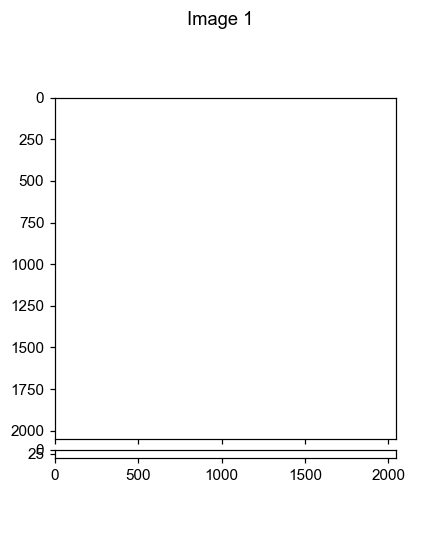

In [12]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, _cls.im_750, corr_labels3d, new_labels])